In [1]:
import numpy as np
import collections
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

(1797, 64)


<Figure size 432x288 with 0 Axes>

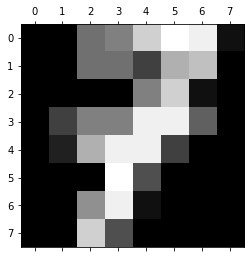

In [2]:
digits = load_digits()
print(digits.data.shape)
plt.gray()
plt.matshow(digits.images[7])

In [3]:
digits.target.shape, digits.data.shape

((1797,), (1797, 64))

In [25]:
digits.target

array([0, 1, 2, ..., 8, 9, 8])

- weight shape:
- w1: (64, 128)
- w2: (128, 10)

In [4]:
# FC Layer
class affineLayer():
    def __init__(self, input_size, output_size):
        self.w = np.random.rand(input_size, output_size) -0.5 
        self.b = np.random.rand(1, output_size) -0.5
        #self.w = np.random.normal(0, 1, [input_size, output_size]) 
        #self.b = np.zeros((1, output_size))

    def forwarding(self, x):
        self.input = x
        # print(self.input.shape)
        self.output = np.dot(self.input, self.w) + self.b
        return self.output
    
    def backward_propagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.w.T)
        weights_error = np.dot(self.input.T, output_error)
        
        self.w -= learning_rate * weights_error
        self.b -= learning_rate * np.sum(output_error)
        return input_error
    

In [5]:
# activation function
class tanhLayer():
    def __init__(self):
        self.z = None

    def forwarding(self, z):
        self.z = z
        return np.tanh(z)
    
    def backward_propagation(self, output_error, learning_rate):
        return (1-np.tanh(self.z)**2)*output_error*learning_rate


In [6]:
# loss function and its derivative
def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2));

def mse_derivative(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size;


In [7]:
# softmax cross entropy loss part
def softmax(output_array):
    logits_exp = np.exp(output_array)
    return logits_exp / np.sum(logits_exp, axis = 1, keepdims = True)

def softmax_derivative(x):
    I = np.eye(x.shape[0])
    return softmax(x) * (I - softmax(x).T)

In [8]:
def softmax_cross_entropy_loss_array(softmax_probs_array, y_onehot):
    indices = np.argmax(y_onehot, axis = 1).astype(int)
    predicted_probability = softmax_probs_array[np.arange(len(softmax_probs_array)), indices]
    log_preds = np.log(predicted_probability)
    loss = -1.0 * np.sum(log_preds) / len(log_preds)
    return loss

In [9]:
def softmax_cross_entropy_derivatives(softmax_probs_array, y_onehot):
    return softmax_probs_array - y_onehot

In [10]:
class VanillaNN(object):
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_derivative = None
        
    def add(self, layer):
        self.layers.append(layer)
    
    def loss_use(self, loss, loss_derivative):
        self.lossfunction = loss
        self.loss_derivative = loss_derivative
    
    # training
    def fit(self, x_train, y_train, epochs, learning_rate):

        # training loop
        for i in range(epochs):
            output = x_train
            for layer in self.layers:
                output = layer.forwarding(output)
            
            softmax_output = softmax(output)
            
            # for display only
            loss = self.lossfunction(softmax_output, y_train)
            error = self.loss_derivative(softmax_output, y_train)
            for layer in reversed(self.layers):
                error = layer.backward_propagation(error, learning_rate)

            if i %1000 ==0:
                print('epoch %d/%d  loss=%f' % (i+1, epochs, loss))  
                
    def predict(self, test_input):
        samples, ans = len(test_input), []
        
        for i in range(samples):
            # forward propagation
            output = test_input[i]
            for layer in self.layers:
                output = layer.forwarding(output)
            ans.append(softmax(output))
        return ans
    

In [11]:
# Network
net = VanillaNN()
net.add(affineLayer(8*8, 128))              
net.add(tanhLayer())
net.add(affineLayer(128, 10))               
net.add(tanhLayer())

In [12]:
# #y one-hot
label = np.array([[0 if j!=i else 1 for j in range(10)] for i in digits.target])

In [13]:
net.loss_use(softmax_cross_entropy_loss_array, softmax_cross_entropy_derivatives)
net.fit(digits.data[:1000], label[:1000], epochs=20000, learning_rate=0.02)

epoch 1/20000  loss=2.696377
epoch 1001/20000  loss=0.825562
epoch 2001/20000  loss=0.814402
epoch 3001/20000  loss=0.808693
epoch 4001/20000  loss=0.806725
epoch 5001/20000  loss=0.805940
epoch 6001/20000  loss=0.805473
epoch 7001/20000  loss=0.805155
epoch 8001/20000  loss=0.803543
epoch 9001/20000  loss=0.803321
epoch 10001/20000  loss=0.803168
epoch 11001/20000  loss=0.803052
epoch 12001/20000  loss=0.802959
epoch 13001/20000  loss=0.802875
epoch 14001/20000  loss=0.802543
epoch 15001/20000  loss=0.802470
epoch 16001/20000  loss=0.802415
epoch 17001/20000  loss=0.802370
epoch 18001/20000  loss=0.802331
epoch 19001/20000  loss=0.802297


In [26]:
predicted = net.predict(digits.data[1000:])

In [27]:
def categorical_accuracy(Y_pred, Y_true):
    Y_true = np.argmax(Y_true, axis=-1)
    Y_pred = np.argmax(Y_pred, axis=-1)
    accuracy = np.mean((Y_true == Y_pred).astype(np.float32))
    return accuracy

In [28]:
categorical_accuracy(np.vstack(np.array(predicted)), label[1000:])

0.89335006